# BitCoin Prediction using Deep Neural Network 

###### Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

Using TensorFlow backend.


###### Load and read the data

In [2]:
# Loading/Reading in the Data
df = pd.read_csv("BTC-USD.csv")

# Data Preprocessing
### Setting the datetime index as the date, only selecting the 'Close' column, then only the last 1000 closing prices.
df = df.set_index("Date")[['Close']].tail(1000)
df = df.set_index(pd.to_datetime(df.index))

# Normalizing/Scaling the Data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [3]:

def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)


def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Create a specified number of hidden layers for an RNN
    Optional: Adds regularization option, dropout layer to prevent potential overfitting if necessary
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

In [4]:
# How many periods looking back to train
n_per_in  = 30

# How many periods ahead to predict
n_per_out = 10

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X, y = split_sequence(list(df.Close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [5]:
# Instantiating the model
model = Sequential()

# Activation
activ = "softsign"

# Input layer
model.add(LSTM(30, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=6, n_nodes=12, activation=activ)

# Final Hidden layer
model.add(LSTM(10, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 12)            2064      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 12)            1200      
_______

In [6]:
model.compile(loss='mean_squared_error', optimizer="Adam", metrics=['accuracy'])

In [7]:
res = model.fit(X, y, epochs=3, batch_size=32, validation_split=0.1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 864 samples, validate on 97 samples
Epoch 1/3
864/864 [==============================] - 31s 36ms/step - loss: 0.1053 - acc: 0.0822 - val_loss: 0.1115 - val_acc: 0.1134
Epoch 2/3
864/864 [==============================] - 9s 11ms/step - loss: 0.0631 - acc: 0.0787 - val_loss: 0.0514 - val_acc: 0.1134
Epoch 3/3
864/864 [==============================] - 12s 14ms/step - loss: 0.0421 - acc: 0.0938 - val_loss: 0.0243 - val_acc: 0.1443


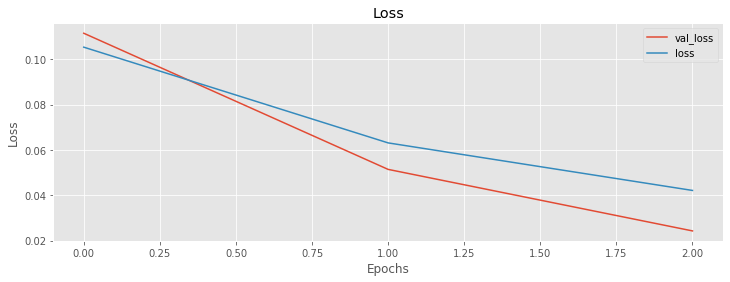

KeyError: 'val_accuracy'

<Figure size 864x288 with 0 Axes>

In [8]:
visualize_training_results(res)

Predicted Prices:
 [[7636.091975266667], [7845.225625602709], [7212.657357131844], [7070.087627881592], [6140.520846489208], [6039.695099426436], [3692.1355390124236], [6387.535989412826], [7124.700675375011], [5078.609451519468]]

Actual Prices:
 [[7531.663573999999], [7463.105956999999], [7761.243651999999], [7569.629883], [7424.29248], [7321.988281], [7320.145508], [7252.034668000001], [7448.307617], [7546.996581999999]]


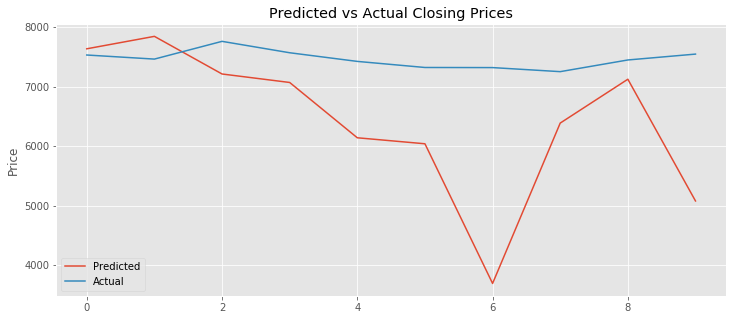

In [9]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = scaler.inverse_transform(y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.savefig("BTC_validation.png")
plt.show()

                  Close
2019-12-06  7629.564517
2019-12-07  7840.241393
2019-12-08  7208.006108
2019-12-09  7065.366684
2019-12-10  6134.891114
2019-12-11  6036.239712
2019-12-12  3691.757200
2019-12-13  6382.411263
2019-12-14  7115.827403
2019-12-15  5079.612272


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


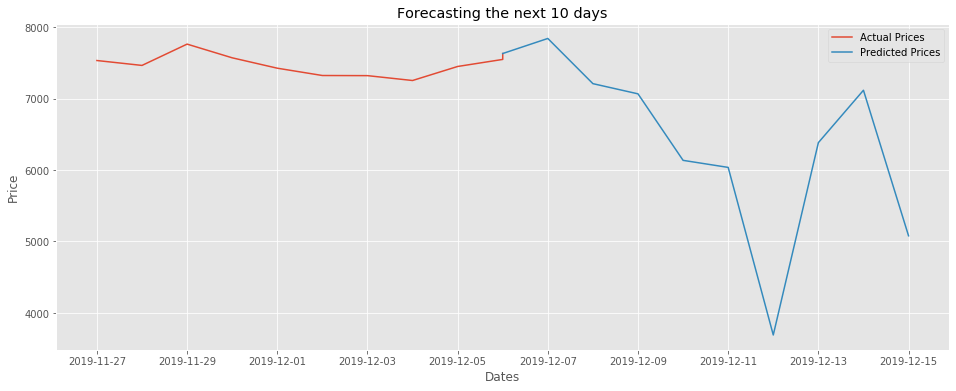

In [10]:

# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(df[["Close"]].tail(pers)), index=df.Close.tail(pers).index, columns=df.columns).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.savefig("BTC_predictions.png")
plt.show()